# Upward sloping demand
In the market for lemons there is upward sloping demand (e.g., if the price is higher, I know the car is not a lemon).
Price no longer measures marginal willingness to pay.
Upward-sloping Marshallian demand is compatible with standard welfare theory when it comes from income effects (Giffen goods), but upward-sloping compensated demand—or price-driven belief effects—violates the negative semidefiniteness of the Slutsky matrix and places the economy outside the domain of the welfare theorems.

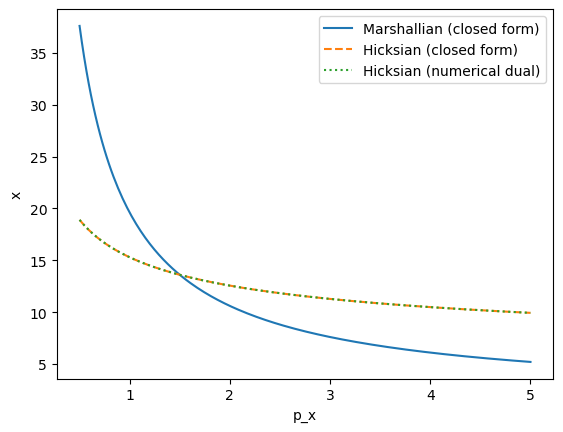

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize_scalar

# Parameters
alpha = 0.6
gamma = 4.0
w = 30.0

# Price grid
p = np.linspace(0.5, 5, 200)

# Utility level to compensate to (pick a baseline price p0)
p0 = 1.5
x0 = gamma + alpha * (w - p0 * gamma) / p0
y0 = (1 - alpha) * (w - p0 * gamma)
u_bar = (x0 - gamma)**alpha * (y0**(1 - alpha))

# Marshallian (closed form)
xM = gamma + alpha * (w - p * gamma) / p

# Hicksian (closed form)
K = (alpha**(1 - alpha)) * ((1 - alpha)**(-(1 - alpha)))
xH_closed = gamma + K * u_bar * (p**(alpha - 1))

# Hicksian (numerical from dual)
def y_needed_stone_geary(x, u_bar, alpha, gamma):
    if x <= gamma:
        return np.inf
    return (u_bar / ((x - gamma)**alpha))**(1/(1 - alpha))

def hicksian_x_numeric(p_i, u_bar, alpha, gamma):
    def exp_obj(x):
        return p_i * x + y_needed_stone_geary(x, u_bar, alpha, gamma)
    # search over a reasonable range
    # lower bound just above gamma; upper bound can be set fairly large
    res = minimize_scalar(exp_obj, bounds=(gamma + 1e-8, gamma + 1e4), method="bounded")
    return res.x

xH_num = np.array([hicksian_x_numeric(pi, u_bar, alpha, gamma) for pi in p])

plt.figure()
plt.plot(p, xM, label="Marshallian (closed form)")
plt.plot(p, xH_closed, "--", label="Hicksian (closed form)")
plt.plot(p, xH_num, ":", label="Hicksian (numerical dual)")
plt.xlabel("p_x")
plt.ylabel("x")
plt.legend()
plt.show()

score: 2.892012573711959
Any Giffen points (dxM/dp>0)? True


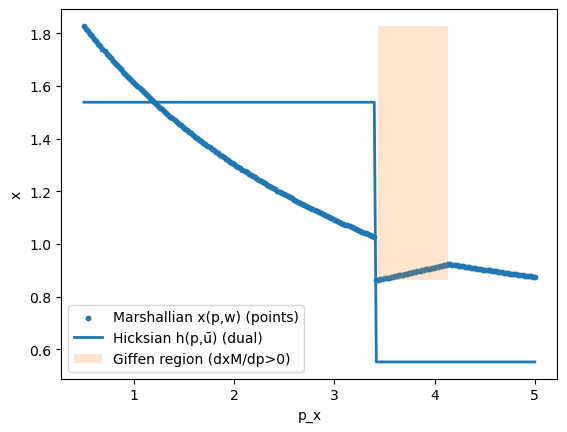

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# -------- Utility: u(x,y)=min_k (a_k x + b_k y + c_k), with a_k,b_k>0 --------
def u_min_affine(x, y, A, B, C):
    return np.min(A*x + B*y + C)

# -------- Marshallian: maximize u(x, w-px) over x in [0, w/p] ---------------
# u(x) becomes min_k { (A_k - B_k p)x + B_k w + C_k }, a concave piecewise-linear function.
# Max occurs at boundaries or at pairwise intersections (kinks).
def marshallian_x_fast(p, w, A, B, C):
    xmax = w / p
    candidates = [0.0, xmax]

    K = len(A)
    for i in range(K):
        for j in range(i+1, K):
            denom = (A[i] - A[j]) - p*(B[i] - B[j])
            if abs(denom) < 1e-12:
                continue
            num = (B[j] - B[i])*w + (C[j] - C[i])
            x_ij = num / denom
            if 0.0 <= x_ij <= xmax:
                candidates.append(float(x_ij))

    # pick x that maximizes u(x, w-px)
    best_x = 0.0
    best_u = -1e300
    for x in candidates:
        y = w - p*x
        if y < -1e-10:
            continue
        val = np.min(A*x + B*y + C)
        if val > best_u:
            best_u, best_x = val, x
    return best_x

# -------- Hicksian via the dual (expenditure minimization) -------------------
# minimize p x + y s.t. A_k x + B_k y + C_k >= ubar for all k, x>=0,y>=0
# Linear objective over polytope => optimum at an extreme point.
def hicksian_x_dual_fast(p, ubar, A, B, C):
    K = len(A)
    candidates = []

    # (i) intersections of two constraints as equalities
    for i in range(K):
        for j in range(i+1, K):
            det = A[i]*B[j] - A[j]*B[i]
            if abs(det) < 1e-12:
                continue
            rhs_i = ubar - C[i]
            rhs_j = ubar - C[j]
            x = ( rhs_i*B[j] - rhs_j*B[i]) / det
            y = (-rhs_i*A[j] + rhs_j*A[i]) / det
            candidates.append((x, y))

    # (ii) intersections with x=0 or y=0 for each constraint
    for i in range(K):
        rhs = ubar - C[i]
        candidates.append((0.0, rhs / B[i]))  # x=0
        candidates.append((rhs / A[i], 0.0))  # y=0

    # (iii) origin
    candidates.append((0.0, 0.0))

    def feasible(x, y):
        if x < -1e-10 or y < -1e-10:
            return False
        return np.all(A*x + B*y + C >= ubar - 1e-9)

    best = None
    best_cost = np.inf
    for x, y in candidates:
        if not feasible(x, y):
            continue
        cost = p*x + y
        if cost < best_cost:
            best_cost = cost
            best = (max(0.0, x), max(0.0, y))

    if best is None:
        return np.nan
    return best[0]

# -------- Find a parameter set that actually shows Giffen --------------------
def find_giffen_params(seed=0, tries=1500):
    rng = np.random.default_rng(seed)

    # keep K small (3 or 4) so it stays fast and easy to see kinks
    K = 4
    w = 10.0
    p_grid = np.linspace(0.5, 5.0, 220)

    best = None
    for t in range(tries):
        # random positive slopes; intercepts allow non-homotheticity (needed for Giffen)
        A = rng.uniform(0.2, 8.0, K)
        B = rng.uniform(0.2, 8.0, K)
        C = rng.uniform(0.0, 6.0, K)

        xM = np.array([marshallian_x_fast(p, w, A, B, C) for p in p_grid])
        dxdp = np.gradient(xM, p_grid)

        # score = total amount of upward movement (Giffen-ness)
        score = np.sum(np.maximum(dxdp, 0.0))

        # ignore degenerate nearly-zero demand cases
        if np.max(xM) < 1e-3:
            continue

        if best is None or score > best["score"]:
            best = dict(score=score, w=w, A=A, B=B, C=C, p_grid=p_grid, xM=xM, dxdp=dxdp)

        # early stop if we found a clear region
        if score > 0.8:
            break

    return best

best = find_giffen_params(seed=1, tries=1500)
print("score:", best["score"])

w = best["w"]
A, B, C = best["A"], best["B"], best["C"]
p_grid = best["p_grid"]
xM = best["xM"]
dxdp = best["dxdp"]

# baseline ubar at p0
p0 = 1.2
x0 = marshallian_x_fast(p0, w, A, B, C)
y0 = w - p0*x0
ubar = u_min_affine(x0, y0, A, B, C)

# Hicksian from the dual
xH = np.array([hicksian_x_dual_fast(p, ubar, A, B, C) for p in p_grid])

print("Any Giffen points (dxM/dp>0)?", np.any(dxdp > 1e-6))

# Plot: use scatter for Marshallian to avoid fake "vertical lines" from jumps
plt.figure()
plt.scatter(p_grid, xM, s=10, label="Marshallian x(p,w) (points)")
plt.plot(p_grid, xH, lw=2, label="Hicksian h(p,ū) (dual)")

plt.fill_between(p_grid, np.min(xM), np.max(xM), where=(dxdp > 0),
                 alpha=0.2, label="Giffen region (dxM/dp>0)")

plt.xlabel("p_x")
plt.ylabel("x")
plt.legend()
plt.show()

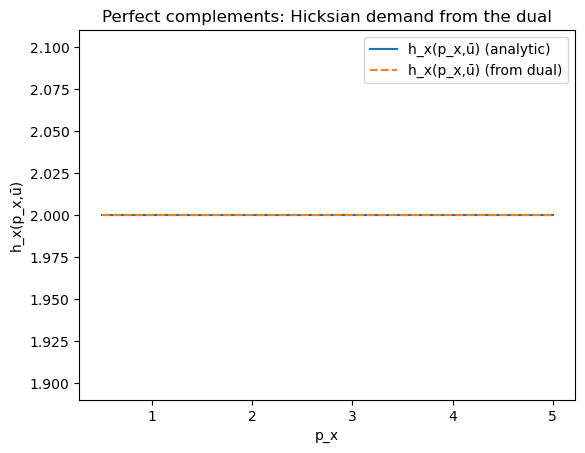

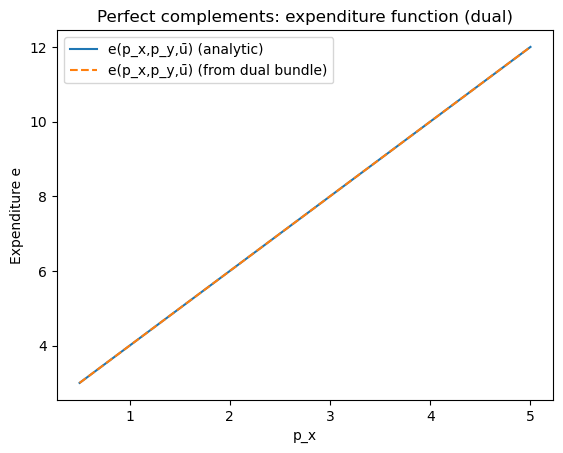

max |h_x_analytic - h_x_dual| = 0.0
max |e_analytic - e_dual|     = 0.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Perfect complements: u(x,y)=min{x,y}
# Dual (expenditure minimization):  e(p,ū)=min_{x,y>=0} p_x x + p_y y  s.t.  min{x,y} >= ū
# Constraint min{x,y} >= ū  <=>  x >= ū AND y >= ū
# So the cost-min bundle is always (ū, ū), and e(p,ū)=ū(p_x+p_y)

u_bar = 2.0
p_x = np.linspace(0.5, 5, 200)
p_y = 1.0

# Hicksian demand (analytic)
h_x_analytic = np.full_like(p_x, u_bar)
h_y_analytic = np.full_like(p_x, u_bar)

# Dual objects (expenditure function)
e_analytic = u_bar * (p_x + p_y)

# "Dual solution" written explicitly from the expenditure minimization logic:
# Since feasible set is x>=u_bar, y>=u_bar and cost is increasing in x,y, minimizer is (u_bar,u_bar).
h_x_dual = np.full_like(p_x, u_bar)
h_y_dual = np.full_like(p_x, u_bar)
e_dual = p_x * h_x_dual + p_y * h_y_dual

# ---- Plot Hicksian demand ----
plt.figure()
plt.plot(p_x, h_x_analytic, label="h_x(p_x,ū) (analytic)")
plt.plot(p_x, h_x_dual, "--", label="h_x(p_x,ū) (from dual)")
plt.xlabel("p_x")
plt.ylabel("h_x(p_x,ū)")
plt.title("Perfect complements: Hicksian demand from the dual")
plt.legend()
plt.show()

# ---- Plot expenditure function ----
plt.figure()
plt.plot(p_x, e_analytic, label="e(p_x,p_y,ū) (analytic)")
plt.plot(p_x, e_dual, "--", label="e(p_x,p_y,ū) (from dual bundle)")
plt.xlabel("p_x")
plt.ylabel("Expenditure e")
plt.title("Perfect complements: expenditure function (dual)")
plt.legend()
plt.show()

# Sanity check
print("max |h_x_analytic - h_x_dual| =", np.max(np.abs(h_x_analytic - h_x_dual)))
print("max |e_analytic - e_dual|     =", np.max(np.abs(e_analytic - e_dual)))